In [1]:
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

url = (
    "https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.csv?"
    "ID,time,latitude,lon360,ve,vn&"
    "time%3E%3D2024-01-01T00%3A00%3A00Z&time%3C%3D2024-12-31T23%3A59%3A59Z&"
    "latitude%3E%3D25&latitude%3C%3D50&lon360%3E%3D225&lon360%3C%3D245"
)

df_raw = pd.read_csv(url)
df = df_raw[pd.to_numeric(df_raw['latitude'], errors='coerce').notnull()].copy()
features = ['latitude', 'lon360', 've', 'vn']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])
print("Data shape:", df_scaled.shape)
print("Unique drifters:", df_scaled['ID'].nunique())
print(df_scaled.head())
print(df_scaled[features].describe())


Data shape: (73438, 6)
Unique drifters: 135
             ID                  time  latitude    lon360        ve        vn
1  3.002341e+14  2024-01-01T00:00:00Z -0.366206 -1.479238  0.035609  0.035608
2  3.002341e+14  2024-01-01T06:00:00Z -0.367458 -1.472326  0.035612  0.035609
3  3.002341e+14  2024-01-01T12:00:00Z -0.367180 -1.469277  0.035611  0.035609
4  3.002341e+14  2024-01-01T18:00:00Z -0.367319 -1.466024  0.035611  0.035609
5  3.002341e+14  2024-01-02T00:00:00Z -0.367319 -1.462162  0.035611  0.035609
           latitude        lon360            ve            vn
count  7.343800e+04  7.343800e+04  7.343800e+04  7.343800e+04
mean   4.458429e-16 -6.638105e-15 -3.096131e-18  1.161049e-17
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00
min   -8.590321e-01 -1.806121e+00 -2.808302e+01 -2.808302e+01
25%   -6.415597e-01 -8.616557e-01  3.560685e-02  3.560693e-02
50%   -3.797023e-01  1.053746e-01  3.560863e-02  3.560881e-02
75%    3.475443e-02  7.969527e-01  3.561046e-02  3.561

In [4]:
num_drifters = df_scaled['ID'].nunique()
print(f"There are {num_drifters} unique drifters in the dataset.")


There are 135 unique drifters in the dataset.


In [11]:
%pip install kneed


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np
import pandas as pd

features = ['latitude', 'lon360', 've', 'vn']
all_results = []

for drifter_id in df_scaled['ID'].unique():
    df_d = df_scaled[df_scaled['ID'] == drifter_id].copy()
    df_d = df_d.dropna(subset=features)

    if len(df_d) < 10:
        continue

    X = df_d[features].values
    X_scaled = StandardScaler().fit_transform(X)

    min_samples = 3
    k = min_samples - 1

    neighbors = NearestNeighbors(n_neighbors=k + 1)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    k_distances = np.sort(distances[:, k])

    try:
        kneedle = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
        eps_optimal = k_distances[kneedle.knee] if kneedle.knee is not None else 0.5
    except:
        eps_optimal = 0.5

    dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    df_d['cluster'] = labels
    df_d['is_anomaly'] = labels == -1
    df_d['eps_used'] = eps_optimal
    all_results.append(df_d)

df_all_drifters_labeled = pd.concat(all_results, ignore_index=True)


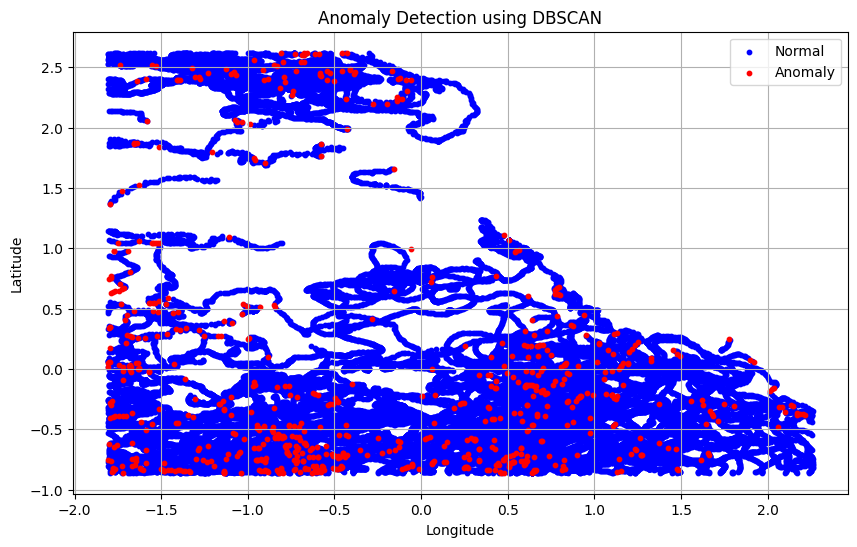

In [12]:
plt.figure(figsize=(10, 6))
normal = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == False]
anomaly = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == True]

plt.scatter(normal['lon360'], normal['latitude'], c='blue', s=10, label='Normal')
plt.scatter(anomaly['lon360'], anomaly['latitude'], c='red', s=10, label='Anomaly')
plt.title('Anomaly Detection using DBSCAN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
num_anomalies = df_all_drifters_labeled['is_anomaly'].sum()
print(f"Number of DBSCAN anomalies detected: {num_anomalies}")


Number of DBSCAN anomalies detected: 738


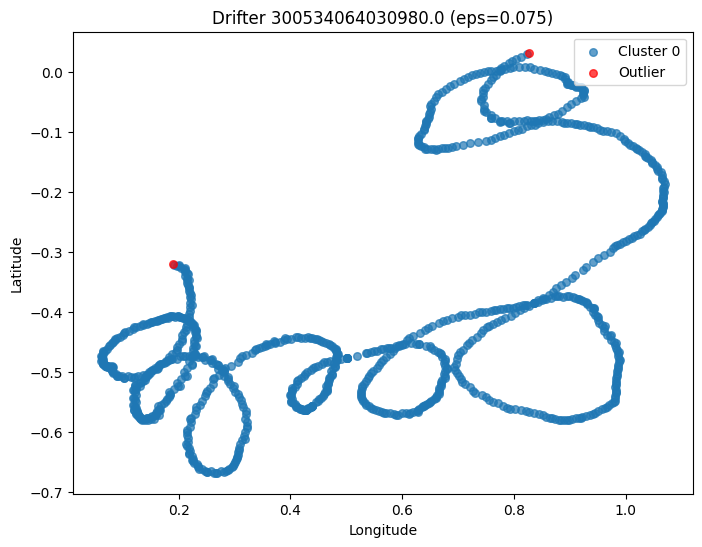

In [14]:
example_id = df_all_drifters_labeled['ID'].sample(1).values[0]
df_example = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == example_id]

plt.figure(figsize=(8, 6))
for label in set(df_example['cluster']):
    mask = df_example['cluster'] == label
    color = 'red' if label == -1 else None
    plt.scatter(df_example[mask]['lon360'], df_example[mask]['latitude'],
                label='Outlier' if label == -1 else f'Cluster {label}', s=30, alpha=0.7, c=color)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Drifter {example_id} (eps={df_example['eps_used'].iloc[0]:.3f})")
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

features = ['latitude', 'lon360', 've', 'vn']
window_size = 10
stride = 1

X_seq, y_seq = [], []

for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])

    if len(df_drifter) < window_size:
        continue

    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values

    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))

X_seq = np.array(X_seq) 
y_seq = np.array(y_seq) 

print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")
print(f"Total anomalies: {np.sum(y_seq)}")


X_seq shape: (72226, 10, 4)
y_seq shape: (72226,)
Total anomalies: 3661


With training curve, new

/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-13 14:06:32.797839: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-12-13 14:06:32.797870: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-13 14:06:32.797876: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-13 14:06:32.797909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-13 14:06:32.797920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

Seed 0 done: Acc=0.931, F1=0.233, best_thresh=0.554


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 1 done: Acc=0.914, F1=0.234, best_thresh=0.568


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 2 done: Acc=0.909, F1=0.224, best_thresh=0.600


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 3 done: Acc=0.929, F1=0.222, best_thresh=0.351


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 4 done: Acc=0.887, F1=0.213, best_thresh=0.586


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 5 done: Acc=0.850, F1=0.192, best_thresh=0.589


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 6 done: Acc=0.925, F1=0.177, best_thresh=0.407


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 7 done: Acc=0.827, F1=0.195, best_thresh=0.570


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 8 done: Acc=0.888, F1=0.202, best_thresh=0.583


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 9 done: Acc=0.904, F1=0.223, best_thresh=0.509
Seed 0 done: Acc=0.923, F1=0.279, best_thresh=0.655
Seed 1 done: Acc=0.912, F1=0.287, best_thresh=0.637
Seed 2 done: Acc=0.896, F1=0.285, best_thresh=0.617
Seed 3 done: Acc=0.899, F1=0.273, best_thresh=0.608
Seed 4 done: Acc=0.920, F1=0.287, best_thresh=0.663
Seed 5 done: Acc=0.942, F1=0.303, best_thresh=0.693
Seed 6 done: Acc=0.889, F1=0.277, best_thresh=0.631
Seed 7 done: Acc=0.927, F1=0.310, best_thresh=0.659
Seed 8 done: Acc=0.903, F1=0.247, best_thresh=0.609
Seed 9 done: Acc=0.904, F1=0.271, best_thresh=0.641
Average Confusion Matrix 80/20 CNN:
 [[12751.2   962.8]
 [  534.1   197.9]]
Average Confusion Matrix 80/20 LSTM:
 [[12916.3   797.7]
 [  482.5   249.5]]


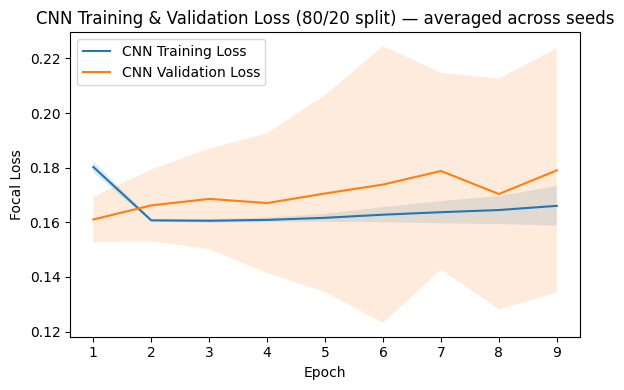

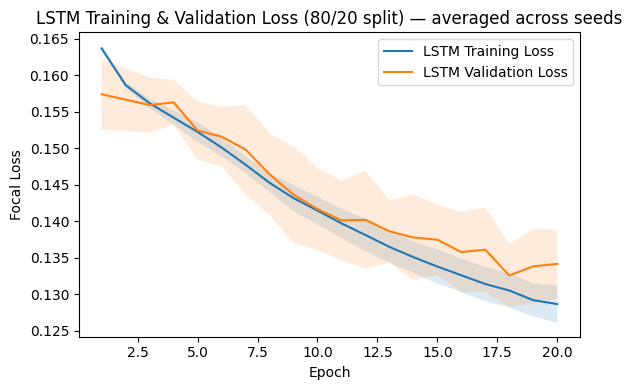

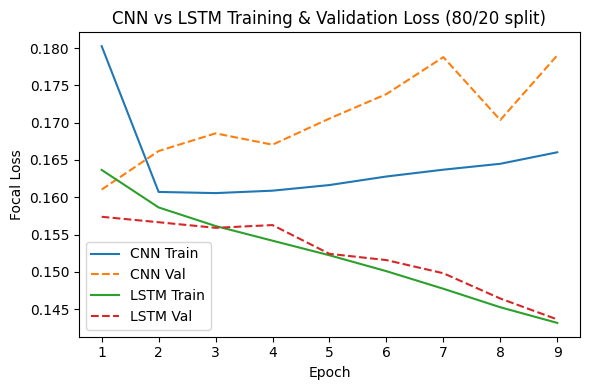

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, auc
)
from tensorflow.keras import layers, models, callbacks, backend as K
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * K.pow(1 - p_t, gamma) * bce
    return loss

def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm_context(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def evaluate_metrics(y_true, y_pred_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    if len(thresholds) == 0:
        best_thresh = 0.5
    else:
        p = precisions[1:]
        r = recalls[1:]
        f1_th = 2 * (p * r) / (p + r + 1e-8)
        best_idx = np.argmax(f1_th)
        best_thresh = thresholds[best_idx]

    y_pred = (y_pred_probs >= best_thresh).astype(int)
    try:
        roc_auc = roc_auc_score(y_true, y_pred_probs)
    except Exception:
        roc_auc = np.nan
    try:
        pr_auc = auc(recalls, precisions)
    except Exception:
        pr_auc = np.nan

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm, best_thresh

def run_experiment(X_seq, y_seq, test_size, seeds, model_type='CNN', epochs=20, batch_size=64, return_history=False):
    all_metrics = []
    all_cms = []
    all_histories = []

    for seed in seeds:
        set_seed(seed)
        tf.keras.backend.clear_session()  
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )
        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]

        if len(X_pos) == 0:
            X_train_bal = X_train_seq.copy()
            y_train_bal = y_train_seq.copy()
        else:
            X_pos_upsampled, y_pos_upsampled = resample(
                X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
            )
            X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
            y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
            shuffle_idx = np.random.permutation(len(X_train_bal))
            X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        input_shape = (X_train_bal.shape[1], X_train_bal.shape[2])
        if model_type == 'CNN':
            model = build_cnn(input_shape)
        else:
            model = build_lstm_context(input_shape)

        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        history = model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )

        if return_history:
            all_histories.append(history.history)

        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm, best_thresh = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        metrics['best_thresh'] = best_thresh
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}, best_thresh={best_thresh:.3f}")

    if return_history:
        return all_metrics, all_cms, all_histories
    return all_metrics, all_cms

def average_confusion_matrices(cms):
    sum_cm = np.zeros_like(cms[0], dtype=float)
    for cm in cms:
        sum_cm += cm
    avg_cm = sum_cm / len(cms)
    return avg_cm

def average_loss_curve(histories, key):
    if len(histories) == 0:
        return np.array([])
    min_len = min(len(h[key]) for h in histories)
    arr = np.array([h[key][:min_len] for h in histories])
    return arr.mean(axis=0), arr.std(axis=0)

seeds = list(range(10)) 
metrics_8020_cnn, cms_8020_cnn, hist_8020_cnn = run_experiment(
    X_seq, y_seq, test_size=0.2, seeds=seeds, model_type='CNN', return_history=True
)

metrics_8020_lstm, cms_8020_lstm, hist_8020_lstm = run_experiment(
    X_seq, y_seq, test_size=0.2, seeds=seeds, model_type='LSTM', return_history=True
)

avg_cm_8020_cnn = average_confusion_matrices(cms_8020_cnn)
avg_cm_8020_lstm = average_confusion_matrices(cms_8020_lstm)

df_metrics_8020_cnn = pd.DataFrame(metrics_8020_cnn)
df_metrics_8020_lstm = pd.DataFrame(metrics_8020_lstm)
print("Average Confusion Matrix 80/20 CNN:\n", avg_cm_8020_cnn)
print("Average Confusion Matrix 80/20 LSTM:\n", avg_cm_8020_lstm)

cnn_train_mean, cnn_train_std = average_loss_curve(hist_8020_cnn, 'loss')
cnn_val_mean, cnn_val_std = average_loss_curve(hist_8020_cnn, 'val_loss')
lstm_train_mean, lstm_train_std = average_loss_curve(hist_8020_lstm, 'loss')
lstm_val_mean, lstm_val_std = average_loss_curve(hist_8020_lstm, 'val_loss')

epochs_cnn = np.arange(1, len(cnn_train_mean) + 1)
epochs_lstm = np.arange(1, len(lstm_train_mean) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_cnn, cnn_train_mean, label='CNN Training Loss')
plt.plot(epochs_cnn, cnn_val_mean, label='CNN Validation Loss')
plt.fill_between(epochs_cnn, cnn_train_mean - cnn_train_std, cnn_train_mean + cnn_train_std, alpha=0.15)
plt.fill_between(epochs_cnn, cnn_val_mean - cnn_val_std, cnn_val_mean + cnn_val_std, alpha=0.15)
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.title("CNN Training & Validation Loss (80/20 split) — averaged across seeds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_lstm, lstm_train_mean, label='LSTM Training Loss')
plt.plot(epochs_lstm, lstm_val_mean, label='LSTM Validation Loss')
plt.fill_between(epochs_lstm, lstm_train_mean - lstm_train_std, lstm_train_mean + lstm_train_std, alpha=0.15)
plt.fill_between(epochs_lstm, lstm_val_mean - lstm_val_std, lstm_val_mean + lstm_val_std, alpha=0.15)
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.title("LSTM Training & Validation Loss (80/20 split) — averaged across seeds")
plt.legend()
plt.tight_layout()
plt.show()

min_epochs = min(len(cnn_train_mean), len(lstm_train_mean))
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, min_epochs + 1), cnn_train_mean[:min_epochs], label='CNN Train')
plt.plot(np.arange(1, min_epochs + 1), cnn_val_mean[:min_epochs], label='CNN Val', linestyle='--')
plt.plot(np.arange(1, min_epochs + 1), lstm_train_mean[:min_epochs], label='LSTM Train')
plt.plot(np.arange(1, min_epochs + 1), lstm_val_mean[:min_epochs], label='LSTM Val', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.title("CNN vs LSTM Training & Validation Loss (80/20 split)")
plt.legend()
plt.tight_layout()
plt.show()


Running 50% training data


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Running 60% training data


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Running 70% training data


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Running 80% training data


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

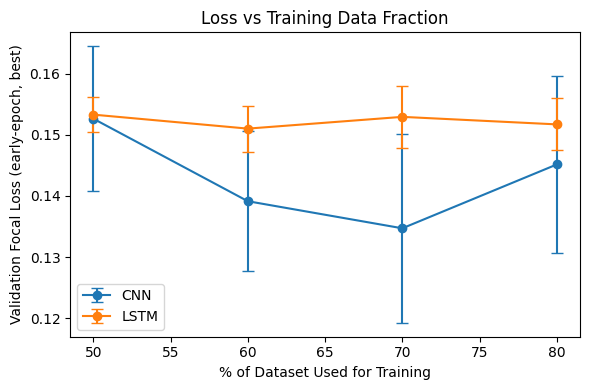

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras import layers, models, callbacks, backend as K

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def focal_loss(alpha=0.25, gamma=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * K.pow(1 - p_t, gamma) * bce
    return loss

def build_cnn(input_shape):
    return models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

def build_lstm_context(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def run_split_fast(
    X_seq,
    y_seq,
    train_frac,
    seeds,
    model_type,
    epochs=5,
    batch_size=64
):
    val_losses = []

    for seed in seeds:
        set_seed(seed)
        tf.keras.backend.clear_session()
        X_train, X_val, y_train, y_val = train_test_split(
            X_seq,
            y_seq,
            test_size=1 - train_frac,
            random_state=seed,
            stratify=y_seq
        )
        X_pos = X_train[y_train == 1]
        y_pos = y_train[y_train == 1]
        X_neg = X_train[y_train == 0]
        y_neg = y_train[y_train == 0]

        if len(X_pos) > 0:
            X_pos_up, y_pos_up = resample(
                X_pos,
                y_pos,
                replace=True,
                n_samples=len(y_neg),
                random_state=seed
            )
            X_train_bal = np.concatenate([X_neg, X_pos_up])
            y_train_bal = np.concatenate([y_neg, y_pos_up])
            perm = np.random.permutation(len(X_train_bal))
            X_train_bal = X_train_bal[perm]
            y_train_bal = y_train_bal[perm]
        else:
            X_train_bal = X_train
            y_train_bal = y_train

        alpha = 1.0 - np.mean(y_train_bal)
        input_shape = (X_train_bal.shape[1], X_train_bal.shape[2])
        model = build_cnn(input_shape) if model_type == "CNN" else build_lstm_context(input_shape)
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy']
        )

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=epochs,            
            restore_best_weights=True
        )
        history = model.fit(
            X_train_bal,
            y_train_bal,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        val_losses.append(np.min(history.history['val_loss']))

    return np.mean(val_losses), np.std(val_losses)

TRAIN_FRACS = [0.5, 0.6, 0.7, 0.8]
SEEDS = list(range(5))    
EPOCHS_FAST = 5

cnn_means, cnn_stds = [], []
lstm_means, lstm_stds = [], []


for frac in TRAIN_FRACS:
    print(f"Running {int(frac * 100)}% training data")

    cnn_mean, cnn_std = run_split_fast(
        X_seq, y_seq,
        train_frac=frac,
        seeds=SEEDS,
        model_type="CNN",
        epochs=EPOCHS_FAST
    )

    lstm_mean, lstm_std = run_split_fast(
        X_seq, y_seq,
        train_frac=frac,
        seeds=SEEDS,
        model_type="LSTM",
        epochs=EPOCHS_FAST
    )

    cnn_means.append(cnn_mean)
    cnn_stds.append(cnn_std)
    lstm_means.append(lstm_mean)
    lstm_stds.append(lstm_std)

x_vals = [f * 100 for f in TRAIN_FRACS]
plt.figure(figsize=(6, 4))
plt.errorbar(x_vals, cnn_means, yerr=cnn_stds, marker='o', capsize=4, label='CNN')
plt.errorbar(x_vals, lstm_means, yerr=lstm_stds, marker='o', capsize=4, label='LSTM')
plt.xlabel("% of Dataset Used for Training")
plt.ylabel("Validation Focal Loss (early-epoch, best)")
plt.title("Loss vs Training Data Fraction")
plt.legend()
plt.tight_layout()
plt.show()


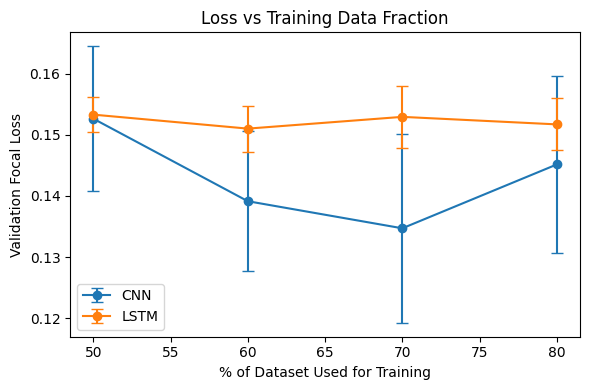

In [19]:
plt.figure(figsize=(6, 4))
plt.errorbar(x_vals, cnn_means, yerr=cnn_stds, marker='o', capsize=4, label='CNN')
plt.errorbar(x_vals, lstm_means, yerr=lstm_stds, marker='o', capsize=4, label='LSTM')
plt.xlabel("% of Dataset Used for Training")
plt.ylabel("Validation Focal Loss")
plt.title("Loss vs Training Data Fraction")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from tensorflow.keras import layers, models, callbacks, backend as K
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * K.pow(1 - p_t, gamma) * bce
    return loss

def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm_context(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def evaluate_metrics(y_true, y_pred_probs):
    best_thresh = 0.5
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    y_pred = (y_pred_probs >= best_thresh).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_probs),
        'pr_auc': auc(recalls, precisions)
    }
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm, best_thresh

def run_experiment(X_seq, y_seq, test_size, seeds, model_type='CNN', epochs=20, batch_size=64):
    all_metrics = []
    all_cms = []

    for seed in seeds:
        set_seed(seed)
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )
        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]

        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )

        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
        shuffle_idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        input_shape = (X_train_bal.shape[1], X_train_bal.shape[2])
        if model_type == 'CNN':
            model = build_cnn(input_shape)
        else:
            model = build_lstm_context(input_shape)
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs, batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm, best_thresh = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        metrics['best_thresh'] = best_thresh
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

def average_confusion_matrices(cms):
    sum_cm = np.zeros_like(cms[0], dtype=float)
    for cm in cms:
        sum_cm += cm
    avg_cm = sum_cm / len(cms)
    return avg_cm

seeds = list(range(10))  

metrics_8020_cnn, cms_8020_cnn = run_experiment(X_seq, y_seq, test_size=0.2, seeds=seeds, model_type='CNN')
metrics_8020_lstm, cms_8020_lstm = run_experiment(X_seq, y_seq, test_size=0.2, seeds=seeds, model_type='LSTM')
metrics_5050_cnn, cms_5050_cnn = run_experiment(X_seq, y_seq, test_size=0.5, seeds=seeds, model_type='CNN')
metrics_5050_lstm, cms_5050_lstm = run_experiment(X_seq, y_seq, test_size=0.5, seeds=seeds, model_type='LSTM')

avg_cm_8020_cnn = average_confusion_matrices(cms_8020_cnn)
avg_cm_5050_cnn = average_confusion_matrices(cms_5050_cnn)
avg_cm_8020_lstm = average_confusion_matrices(cms_8020_lstm)
avg_cm_5050_lstm = average_confusion_matrices(cms_5050_lstm)

df_metrics_8020_cnn = pd.DataFrame(metrics_8020_cnn)
df_metrics_5050_cnn = pd.DataFrame(metrics_5050_cnn)
df_metrics_8020_lstm = pd.DataFrame(metrics_8020_lstm)
df_metrics_5050_lstm = pd.DataFrame(metrics_5050_lstm)

print("Average Confusion Matrix 80/20 CNN:\n", avg_cm_8020_cnn)
print("Average Confusion Matrix 50/50 CNN:\n", avg_cm_5050_cnn)
print("Average Confusion Matrix 80/20 LSTM:\n", avg_cm_8020_lstm)
print("Average Confusion Matrix 50/50 LSTM:\n", avg_cm_5050_lstm)


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-28 02:03:39.842509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-28 02:03:39.842558: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-28 02:03:39.842568: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-28 02:03:39.842851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-28 02:03:39.842865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

Seed 0 done: Acc=0.931, F1=0.233


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 1 done: Acc=0.914, F1=0.234


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 2 done: Acc=0.909, F1=0.224


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 3 done: Acc=0.929, F1=0.223


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 4 done: Acc=0.887, F1=0.213


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 5 done: Acc=0.850, F1=0.192


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 6 done: Acc=0.925, F1=0.177


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 7 done: Acc=0.827, F1=0.195


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 8 done: Acc=0.888, F1=0.202


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 9 done: Acc=0.904, F1=0.224
Seed 0 done: Acc=0.923, F1=0.280
Seed 1 done: Acc=0.912, F1=0.287
Seed 2 done: Acc=0.896, F1=0.285
Seed 3 done: Acc=0.899, F1=0.273
Seed 4 done: Acc=0.920, F1=0.287
Seed 5 done: Acc=0.942, F1=0.303
Seed 6 done: Acc=0.889, F1=0.277
Seed 7 done: Acc=0.927, F1=0.310
Seed 8 done: Acc=0.903, F1=0.247
Seed 9 done: Acc=0.904, F1=0.271


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 0 done: Acc=0.906, F1=0.246


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 1 done: Acc=0.931, F1=0.237


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 2 done: Acc=0.906, F1=0.237


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 3 done: Acc=0.882, F1=0.218


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 4 done: Acc=0.857, F1=0.218


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 5 done: Acc=0.864, F1=0.204


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 6 done: Acc=0.927, F1=0.273


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 7 done: Acc=0.912, F1=0.260


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 8 done: Acc=0.936, F1=0.210


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 9 done: Acc=0.910, F1=0.260
Seed 0 done: Acc=0.888, F1=0.240
Seed 1 done: Acc=0.902, F1=0.262
Seed 2 done: Acc=0.896, F1=0.278
Seed 3 done: Acc=0.898, F1=0.244
Seed 4 done: Acc=0.891, F1=0.250
Seed 5 done: Acc=0.897, F1=0.243
Seed 6 done: Acc=0.894, F1=0.235
Seed 7 done: Acc=0.899, F1=0.273
Seed 8 done: Acc=0.914, F1=0.246
Seed 9 done: Acc=0.861, F1=0.235
Average Confusion Matrix 80/20 CNN:
 [[12752.2   961.8]
 [  534.1   197.9]]
Average Confusion Matrix 50/50 CNN:
 [[32083.6  2199.4]
 [ 1296.5   533.5]]
Average Confusion Matrix 80/20 LSTM:
 [[12917.3   796.7]
 [  482.5   249.5]]
Average Confusion Matrix 50/50 LSTM:
 [[31652.8  2630.2]
 [ 1191.8   638.2]]


In [ ]:
#hyperparameter testing

#longer window
window_size_long = 20
stride = 1

X_seq_20, y_seq_20 = [], []

for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    
    if len(df_drifter) < window_size_long:
        continue

    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values

    for i in range(0, len(values) - window_size_long + 1, stride):
        X_seq_20.append(values[i:i + window_size_long])
        y_seq_20.append(int(np.max(labels[i:i + window_size_long])))

X_seq_20 = np.array(X_seq_20)
y_seq_20 = np.array(y_seq_20)

print(f"X_seq_20 shape: {X_seq_20.shape}, y_seq_20 shape: {y_seq_20.shape}")
metrics_cnn_w20, cms_cnn_w20 = run_experiment(X_seq_20, y_seq_20, test_size=0.2, seeds=seeds, model_type='CNN')
metrics_lstm_w20, cms_lstm_w20 = run_experiment(X_seq_20, y_seq_20, test_size=0.2, seeds=seeds, model_type='LSTM')

avg_cm_cnn_w20 = average_confusion_matrices(cms_cnn_w20)
avg_cm_lstm_w20 = average_confusion_matrices(cms_lstm_w20)

df_metrics_cnn_w20 = pd.DataFrame(metrics_cnn_w20)
df_metrics_lstm_w20 = pd.DataFrame(metrics_lstm_w20)

print("Average Confusion Matrix (CNN w=20):\n", avg_cm_cnn_w20)
print("Average Confusion Matrix (LSTM w=20):\n", avg_cm_lstm_w20)


#deep cnn
def build_cnn_deep(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model
def run_experiment_cnn_deep(X_seq, y_seq, test_size, seeds, epochs=20, batch_size=64):
    all_metrics, all_cms = [], []
    for seed in seeds:
        set_seed(seed)
        X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=test_size,
                                                          random_state=seed, stratify=y_seq)
        X_pos, y_pos = X_train[y_train == 1], y_train[y_train == 1]
        X_neg, y_neg = X_train[y_train == 0], y_train[y_train == 0]
        X_pos_up, y_pos_up = resample(X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed)
        X_train_bal = np.concatenate([X_neg, X_pos_up])
        y_train_bal = np.concatenate([y_neg, y_pos_up])
        idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[idx], y_train_bal[idx]
        alpha = 1 - np.mean(y_train_bal)
        model = build_cnn_deep((X_train_bal.shape[1], X_train_bal.shape[2]))
        model.compile(optimizer='adam',
                      loss=focal_loss(alpha=alpha, gamma=1.0),
                      metrics=['accuracy', tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(X_train_bal, y_train_bal, validation_data=(X_val, y_val),
                  epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)
        y_val_probs = model.predict(X_val, verbose=0).ravel()
        metrics, cm, best_thresh = evaluate_metrics(y_val, y_val_probs)
        metrics['seed'] = seed
        metrics['best_thresh'] = best_thresh
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"Deep CNN Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms
metrics_cnn_deep, cms_cnn_deep = run_experiment_cnn_deep(X_seq, y_seq, test_size=0.2, seeds=seeds)
avg_cm_cnn_deep = average_confusion_matrices(cms_cnn_deep)
df_metrics_cnn_deep = pd.DataFrame(metrics_cnn_deep)
print("Average Confusion Matrix (Deep CNN 3-layer):\n", avg_cm_cnn_deep)



#LSTM with 32 units
def build_lstm_32(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(32, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def run_experiment_lstm_32(X_seq, y_seq, test_size, seeds, epochs=20, batch_size=64):
    all_metrics, all_cms = [], []
    for seed in seeds:
        set_seed(seed)
        X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=test_size,
                                                          random_state=seed, stratify=y_seq)
        X_pos, y_pos = X_train[y_train == 1], y_train[y_train == 1]
        X_neg, y_neg = X_train[y_train == 0], y_train[y_train == 0]
        X_pos_up, y_pos_up = resample(X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed)
        X_train_bal = np.concatenate([X_neg, X_pos_up])
        y_train_bal = np.concatenate([y_neg, y_pos_up])
        idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[idx], y_train_bal[idx]
        alpha = 1 - np.mean(y_train_bal)
        model = build_lstm_32((X_train_bal.shape[1], X_train_bal.shape[2]))
        model.compile(optimizer='adam',
                      loss=focal_loss(alpha=alpha, gamma=1.0),
                      metrics=['accuracy', tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(X_train_bal, y_train_bal, validation_data=(X_val, y_val),
                  epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)
        y_val_probs = model.predict(X_val, verbose=0).ravel()
        metrics, cm, best_thresh = evaluate_metrics(y_val, y_val_probs)
        metrics['seed'] = seed
        metrics['best_thresh'] = best_thresh
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"LSTM(32) Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

metrics_lstm_32, cms_lstm_32 = run_experiment_lstm_32(X_seq, y_seq, test_size=0.2, seeds=seeds)
avg_cm_lstm_32 = average_confusion_matrices(cms_lstm_32)
df_metrics_lstm_32 = pd.DataFrame(metrics_lstm_32)
print("Average Confusion Matrix (LSTM-32):\n", avg_cm_lstm_32)


X_seq_20 shape: (70904, 20, 4), y_seq_20 shape: (70904,)


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 0 done: Acc=0.866, F1=0.302


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 1 done: Acc=0.891, F1=0.270


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 2 done: Acc=0.889, F1=0.371


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 3 done: Acc=0.874, F1=0.396


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 4 done: Acc=0.815, F1=0.266


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 5 done: Acc=0.855, F1=0.294


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 6 done: Acc=0.821, F1=0.313


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 7 done: Acc=0.823, F1=0.281


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 8 done: Acc=0.866, F1=0.356


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 9 done: Acc=0.855, F1=0.309
Seed 0 done: Acc=0.851, F1=0.272
Seed 1 done: Acc=0.848, F1=0.339
Seed 2 done: Acc=0.872, F1=0.334
Seed 3 done: Acc=0.849, F1=0.364
Seed 4 done: Acc=0.853, F1=0.346
Seed 5 done: Acc=0.850, F1=0.351
Seed 6 done: Acc=0.835, F1=0.362
Seed 7 done: Acc=0.856, F1=0.357
Seed 8 done: Acc=0.848, F1=0.323
Seed 9 done: Acc=0.795, F1=0.335
Average Confusion Matrix (CNN w=20):
 [[11660.9  1316.1]
 [  733.3   470.7]]
Average Confusion Matrix (LSTM w=20):
 [[11429.8  1547.2]
 [  642.1   561.9]]


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 0 done: Acc=0.921, F1=0.256


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 1 done: Acc=0.929, F1=0.289


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 2 done: Acc=0.896, F1=0.231


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 3 done: Acc=0.923, F1=0.309


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 4 done: Acc=0.890, F1=0.229


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 5 done: Acc=0.930, F1=0.303


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 6 done: Acc=0.928, F1=0.256


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 7 done: Acc=0.919, F1=0.268


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 8 done: Acc=0.918, F1=0.330


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep CNN Seed 9 done: Acc=0.932, F1=0.332
Average Confusion Matrix (Deep CNN 3-layer):
 [[13042.6   671.4]
 [  505.5   226.5]]
LSTM(32) Seed 0 done: Acc=0.853, F1=0.249
LSTM(32) Seed 1 done: Acc=0.898, F1=0.259
LSTM(32) Seed 2 done: Acc=0.879, F1=0.261
LSTM(32) Seed 3 done: Acc=0.858, F1=0.239
LSTM(32) Seed 4 done: Acc=0.896, F1=0.251
LSTM(32) Seed 5 done: Acc=0.902, F1=0.262
LSTM(32) Seed 6 done: Acc=0.882, F1=0.226
LSTM(32) Seed 7 done: Acc=0.842, F1=0.233
LSTM(32) Seed 8 done: Acc=0.894, F1=0.193
LSTM(32) Seed 9 done: Acc=0.900, F1=0.253
Average Confusion Matrix (LSTM-32):
 [[12442.3  1271.7]
 [  455.5   276.5]]


In [ ]:
print("CNN w=20 Metrics:\n", df_metrics_cnn_w20)
print("\nLSTM w=20 Metrics:\n", df_metrics_lstm_w20)
print("\nDeep CNN (3-layer) Metrics:\n", df_metrics_cnn_deep)
print("\nLSTM(32) Metrics: \n", df_metrics_lstm_32)


CNN w=20 Metrics:
    accuracy  precision    recall        f1   roc_auc    pr_auc  seed  \
0  0.865806   0.270519  0.342193  0.302164  0.738798  0.269620     0   
1  0.890769   0.311887  0.237542  0.269684  0.563310  0.218761     1   
2  0.888936   0.357198  0.385382  0.370755  0.770872  0.341437     2   
3  0.874127   0.334284  0.486711  0.396348  0.826609  0.370950     3   
4  0.815175   0.200423  0.393688  0.265621  0.708894  0.237307     4   
5  0.854947   0.250731  0.356312  0.294340  0.713766  0.251142     5   
6  0.821240   0.232409  0.480066  0.313194  0.786997  0.289452     6   
7  0.823073   0.214692  0.407807  0.281295  0.702531  0.225309     7   
8  0.865595   0.300114  0.437708  0.356081  0.767714  0.297630     8   
9  0.855158   0.259887  0.382060  0.309348  0.751626  0.287307     9   

   best_thresh  
0     0.493851  
1     0.408899  
2     0.557440  
3     0.574072  
4     0.549225  
5     0.543523  
6     0.456003  
7     0.552264  
8     0.530177  
9     0.513389  



In [ ]:
window_size = 10
stride = 1
X_seq, y_seq = [], []

for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    if len(df_drifter) < window_size:
        continue
    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values
    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq) 
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")
print(f"Total anomalies: {np.sum(y_seq)}")


X_seq shape: (72226, 10, 4)
y_seq shape: (72226,)
Total anomalies: 3661


In [ ]:
#Logistic regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)
X_mean = np.mean(X_seq, axis=1)
X_std = np.std(X_seq, axis=1)
X_max = np.max(X_seq, axis=1)
X_min = np.min(X_seq, axis=1)
X_agg = np.concatenate([X_mean, X_std, X_max, X_min], axis=1)

seeds = list(range(10))
all_metrics_lr = []
for seed in seeds:
    np.random.seed(seed)
    X_train, X_val, y_train, y_val = train_test_split(
        X_agg, y_seq, test_size=0.2, stratify=y_seq, random_state=seed
    )
    X_pos = X_train[y_train==1]
    y_pos = y_train[y_train==1]
    X_neg = X_train[y_train==0]
    y_neg = y_train[y_train==0]

    if len(X_pos) > 0:
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
    else:
        X_train_bal, y_train_bal = X_train, y_train 

    shuffle_idx = np.random.permutation(len(X_train_bal))
    X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)

    model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=seed)
    model_lr.fit(X_train_scaled, y_train_bal)
    y_val_probs = model_lr.predict_proba(X_val_scaled)[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    y_val_pred = (y_val_probs >= best_thresh).astype(int)
    metrics = {
        'seed': seed,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, zero_division=0),
        'recall': recall_score(y_val, y_val_pred, zero_division=0),
        'f1': f1_score(y_val, y_val_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_val, y_val_probs),
        'pr_auc': auc(recalls, precisions),
        'best_thresh': best_thresh
    }
    all_metrics_lr.append(metrics)
    print(f"Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")

df_metrics_lr = pd.DataFrame(all_metrics_lr)
print(df_metrics_lr.describe())


Seed 0 done: Acc=0.921, F1=0.310
Seed 1 done: Acc=0.911, F1=0.307
Seed 2 done: Acc=0.908, F1=0.301
Seed 3 done: Acc=0.864, F1=0.252
Seed 4 done: Acc=0.891, F1=0.259
Seed 5 done: Acc=0.895, F1=0.255
Seed 6 done: Acc=0.896, F1=0.249
Seed 7 done: Acc=0.852, F1=0.251
Seed 8 done: Acc=0.852, F1=0.235
Seed 9 done: Acc=0.890, F1=0.253
           seed   accuracy  precision     recall         f1    roc_auc  \
count  10.00000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    4.50000   0.887997   0.206510   0.396038   0.267280   0.793452   
std     3.02765   0.024286   0.039297   0.050283   0.027701   0.023841   
min     0.00000   0.851724   0.159533   0.338798   0.235294   0.769899   
25%     2.25000   0.870327   0.179079   0.357582   0.250845   0.778763   
50%     4.50000   0.892946   0.197125   0.383197   0.254040   0.783183   
75%     6.75000   0.905060   0.233430   0.434085   0.290892   0.813376   
max     9.00000   0.920878   0.277838   0.489071   0.310199   0.832840   

   

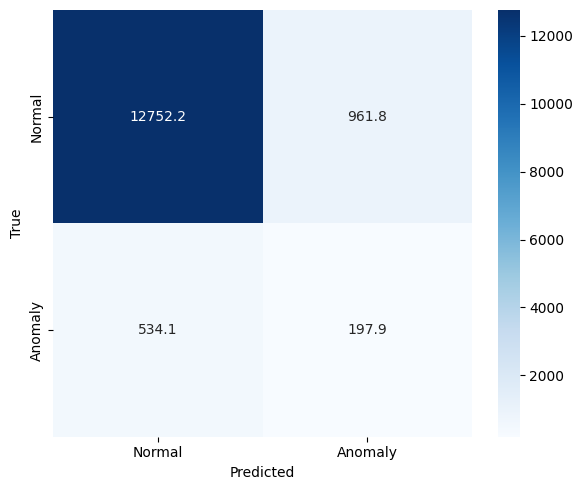

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = np.array([[12752.2, 961.8],
                        [534.1, 197.9]])

labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


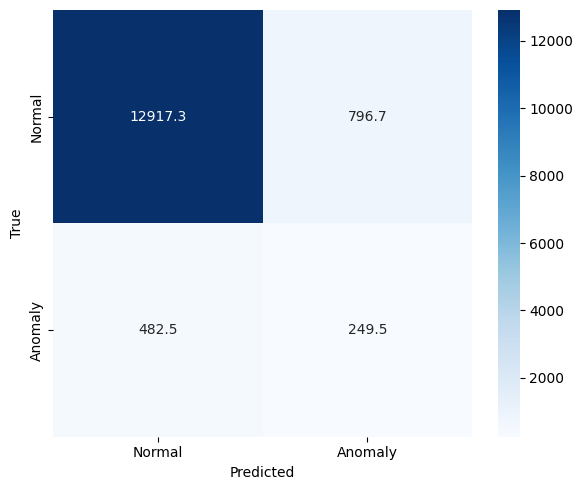

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = np.array([[12917.3, 796.7],
                        [482.5, 249.5]])
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


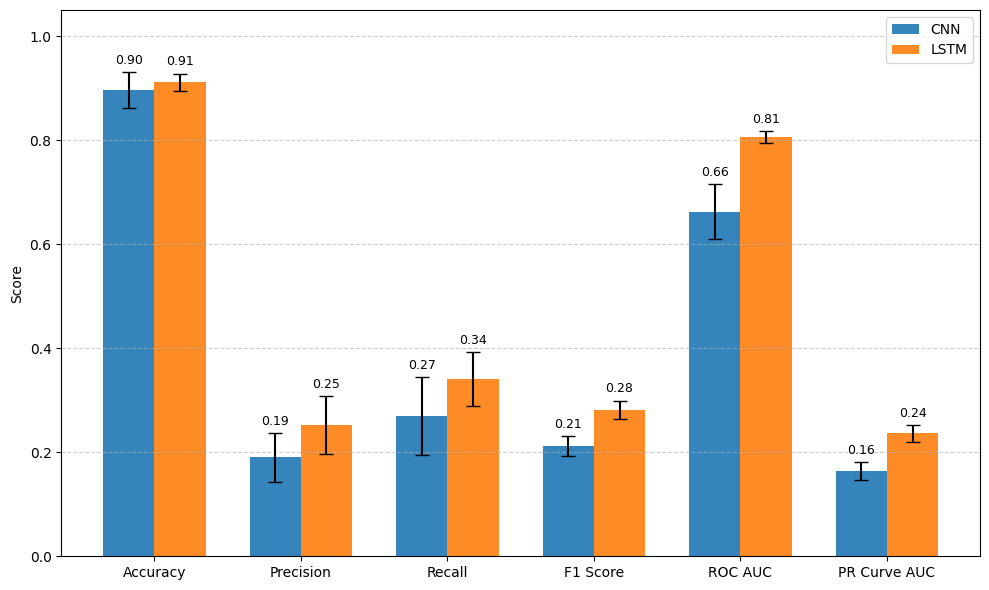

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_cnn = pd.DataFrame(metrics_8020_cnn)
df_lstm = pd.DataFrame(metrics_8020_lstm)

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR Curve AUC']

cnn_means = [df_cnn[m].mean() for m in metrics_to_plot]
cnn_stds = [df_cnn[m].std() for m in metrics_to_plot]
lstm_means = [df_lstm[m].mean() for m in metrics_to_plot]
lstm_stds = [df_lstm[m].std() for m in metrics_to_plot]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, cnn_means, width, yerr=cnn_stds, capsize=5, label='CNN', color='#1f77b4', alpha=0.9)
bars2 = plt.bar(x + width/2, lstm_means, width, yerr=lstm_stds, capsize=5, label='LSTM', color='#ff7f0e', alpha=0.9)

plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(x, labels)
plt.legend()

for bars, means, stds in zip([bars1, bars2], [cnn_means, lstm_means], [cnn_stds, lstm_stds]):
    for bar, mean, std in zip(bars, means, stds):
        offset = std + 0.01
        plt.annotate(f'{mean:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, mean + offset),
                     xytext=(0, 0),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


95% CI for mean difference (CNN - LSTM): [-0.0877, -0.0552]
Observed mean difference         : -0.0705
95% CI for mean difference (CNN - LSTM): [-0.0296, 0.0026]
Observed mean difference         : -0.0145


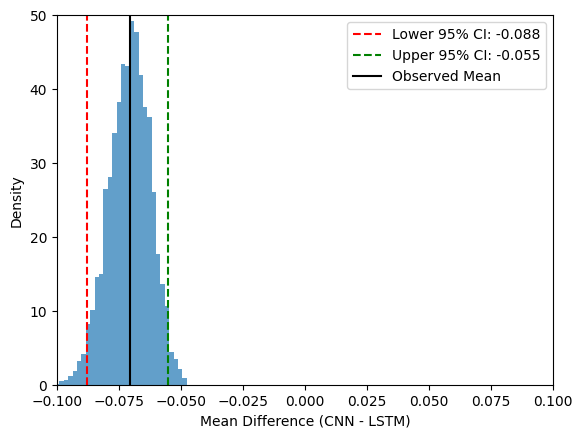

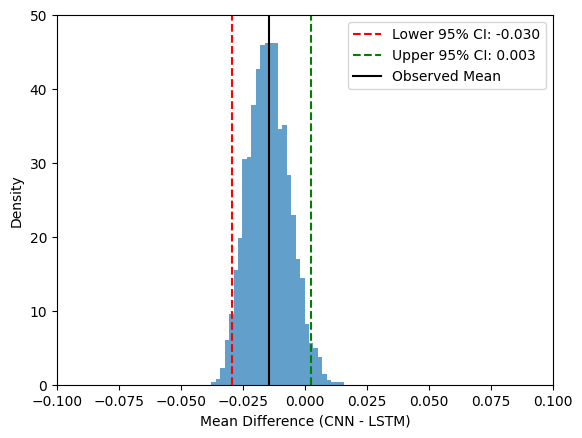

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def extract_f1(df_metrics):
    return df_metrics['f1'].values

f1_8020_cnn = extract_f1(df_metrics_8020_cnn)
f1_8020_lstm = extract_f1(df_metrics_8020_lstm)
f1_5050_cnn = extract_f1(df_metrics_5050_cnn)
f1_5050_lstm = extract_f1(df_metrics_5050_lstm)

def shuffle_in_blocks(arr1, arr2, block_size):
    n = len(arr1)
    n_blocks = n // block_size
    leftover = n % block_size

    b1 = arr1[:n_blocks*block_size].reshape(n_blocks, block_size)
    b2 = arr2[:n_blocks*block_size].reshape(n_blocks, block_size)

    perm = np.random.permutation(n_blocks)
    s1 = b1[perm].reshape(-1)
    s2 = b2[perm].reshape(-1)

    if leftover:
        s1 = np.concatenate([s1, arr1[-leftover:]])
        s2 = np.concatenate([s2, arr2[-leftover:]])

    return s1, s2

def bootstrap_mean_diff(arr1, arr2, block_size=2, n_boot=5000, ci=95):
    diffs = np.empty(n_boot)
    n = len(arr1)

    for i in range(n_boot):
        s1, s2 = shuffle_in_blocks(arr1, arr2, block_size)
        idx = np.random.choice(n, n, replace=True)
        diffs[i] = np.mean(s1[idx] - s2[idx])

    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    obs_diff = np.mean(arr1 - arr2)

    print(f"{ci}% CI for mean difference (CNN - LSTM): [{lower:.4f}, {upper:.4f}]")
    print(f"Observed mean difference         : {obs_diff:.4f}")
    return diffs, lower, upper

boot_8020, ci_lo_8020, ci_hi_8020 = bootstrap_mean_diff(f1_8020_cnn, f1_8020_lstm)
boot_5050, ci_lo_5050, ci_hi_5050 = bootstrap_mean_diff(f1_5050_cnn, f1_5050_lstm)

def plot_bootstrap(diffs, ci_lo, ci_hi):
    plt.hist(diffs, bins=30, density=True, alpha=0.7)
    plt.axvline(ci_lo, color='red', linestyle='--', label=f"Lower 95% CI: {ci_lo:.3f}")
    plt.axvline(ci_hi, color='green', linestyle='--', label=f"Upper 95% CI: {ci_hi:.3f}")
    plt.axvline(np.mean(diffs), color='black', linestyle='-', label="Observed Mean")
    plt.xlim(-0.1, 0.1)
    plt.ylim(0,50)
    plt.xlabel("Mean Difference (CNN - LSTM)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_bootstrap(boot_8020, ci_lo_8020, ci_hi_8020)
plot_bootstrap(boot_5050, ci_lo_5050, ci_hi_5050)


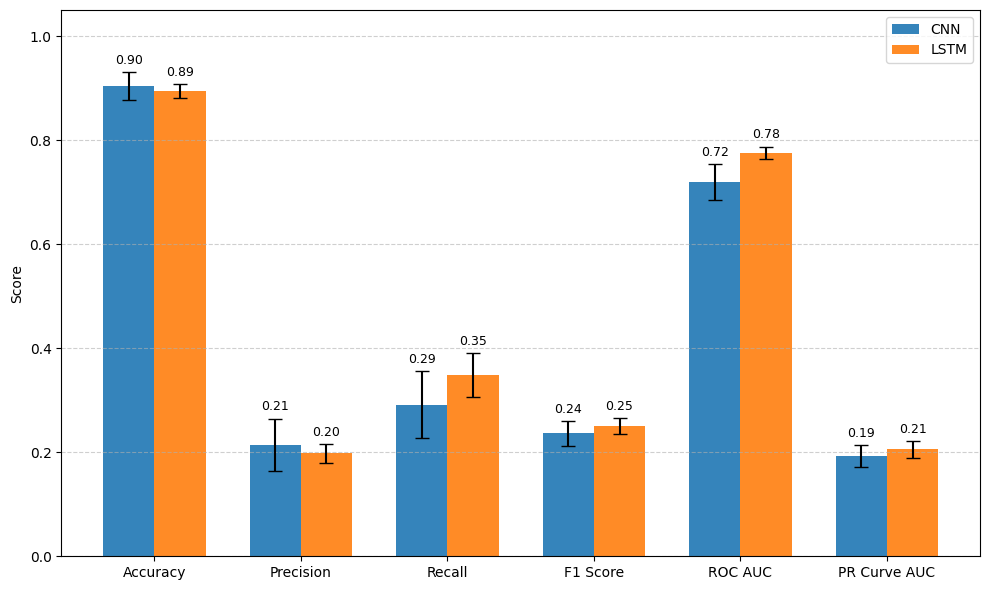

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_cnn = pd.DataFrame(metrics_5050_cnn)
df_lstm = pd.DataFrame(metrics_5050_lstm)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR Curve AUC']

cnn_means = [df_cnn[m].mean() for m in metrics_to_plot]
cnn_stds = [df_cnn[m].std() for m in metrics_to_plot]
lstm_means = [df_lstm[m].mean() for m in metrics_to_plot]
lstm_stds = [df_lstm[m].std() for m in metrics_to_plot]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, cnn_means, width, yerr=cnn_stds, capsize=5, label='CNN', color='#1f77b4', alpha=0.9)
bars2 = plt.bar(x + width/2, lstm_means, width, yerr=lstm_stds, capsize=5, label='LSTM', color='#ff7f0e', alpha=0.9)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(x, labels)
plt.legend()

for bars, means, stds in zip([bars1, bars2], [cnn_means, lstm_means], [cnn_stds, lstm_stds]):
    for bar, mean, std in zip(bars, means, stds):
        offset = std + 0.01
        plt.annotate(f'{mean:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, mean + offset),
                     xytext=(0, 0),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
#CNN
mean_f1_8020_cnn = df_metrics_8020_cnn['f1'].mean()
mean_f1_5050_cnn = df_metrics_5050_cnn['f1'].mean()

#LSTM
mean_f1_8020_lstm = df_metrics_8020_lstm['f1'].mean()
mean_f1_5050_lstm = df_metrics_5050_lstm['f1'].mean()

print(f"CNN 80/20 mean F1: {mean_f1_8020_cnn:.3f}, CNN 50/50 mean F1: {mean_f1_5050_cnn:.3f}")
print(f"LSTM 80/20 mean F1: {mean_f1_8020_lstm:.3f}, LSTM 50/50 mean F1: {mean_f1_5050_lstm:.3f}")


CNN 80/20 mean F1: 0.212, CNN 50/50 mean F1: 0.236
LSTM 80/20 mean F1: 0.282, LSTM 50/50 mean F1: 0.251


In [36]:
print("CNN 80/20 metrics:\n", df_metrics_8020_cnn)
print("\nCNN 50/50 metrics:\n", df_metrics_5050_cnn)
print("\nLSTM 80/20 metrics:\n", df_metrics_8020_lstm)
print("\nLSTM 50/50 metrics:\n", df_metrics_5050_lstm)


CNN 80/20 metrics:
    accuracy  precision    recall        f1   roc_auc    pr_auc  seed  \
0  0.931192   0.267730  0.206284  0.233025  0.663983  0.174520     0   
1  0.913748   0.212528  0.259563  0.233702  0.643187  0.175421     1   
2  0.909317   0.197699  0.258197  0.223934  0.706130  0.173517     2   
3  0.929392   0.251724  0.199454  0.222561  0.562732  0.162453     3   
4  0.887443   0.164918  0.300546  0.212972  0.704118  0.191874     4   
5  0.849855   0.132104  0.352459  0.192179  0.692396  0.168022     5   
6  0.924893   0.199319  0.159836  0.177407  0.581360  0.127010     6   
7  0.826596   0.127677  0.415301  0.195310  0.707468  0.152917     7   
8  0.888204   0.158017  0.278689  0.201681  0.695791  0.152298     8   
9  0.903849   0.189215  0.273224  0.223589  0.666786  0.163891     9   

   best_thresh  
0     0.553739  
1     0.568145  
2     0.599769  
3     0.351033  
4     0.586053  
5     0.588568  
6     0.406980  
7     0.570299  
8     0.582795  
9     0.508990  


In [ ]:
%pip install reedsolo


Note: you may need to restart the kernel to use updated packages.


Original data shape: (100, 2) (rows = 100, columns = lat/lon)
Original data bytes length: 800
Encoded bytes length: 960
Corrupted entire rows (dropouts): [1, 39, 82, 15, 55]


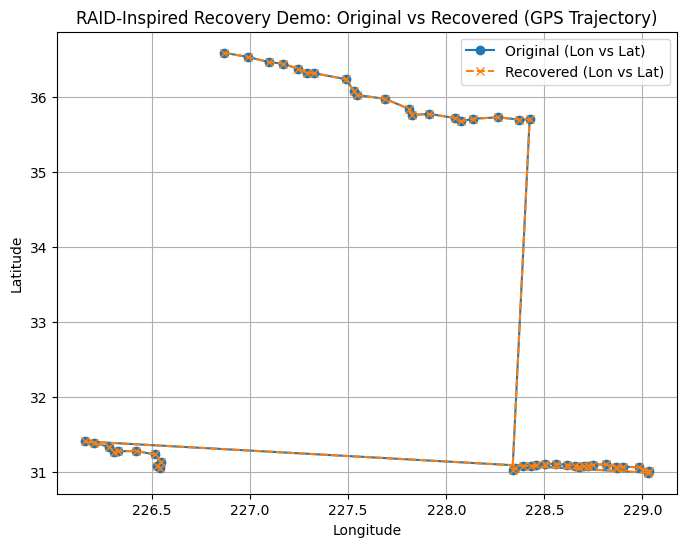

Reconstruction MSE: 0.0000000000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from statsmodels.stats.contingency_tables import mcnemar
import random
import reedsolo

selected_ids = df['ID'].unique()[:5]
sample_block = pd.concat([
    df[df['ID'] == drifter_id].sort_values('time').iloc[20:40]
    for drifter_id in selected_ids
])
data_block = sample_block[['latitude', 'lon360']].values
print(f"Original data shape: {data_block.shape} (rows = {data_block.shape[0]}, columns = lat/lon)")

data_block = np.array(data_block, dtype=float)
data_flat = (data_block.flatten() * 1e5).astype(np.int32)
data_bytes = data_flat.tobytes()
print(f"Original data bytes length: {len(data_bytes)}")

rs = reedsolo.RSCodec(40) 
encoded_bytes = rs.encode(data_bytes)
print(f"Encoded bytes length: {len(encoded_bytes)}")

n_rows = data_block.shape[0]
row_size = data_block.shape[1] * 4 
row_byte_indices = [i * row_size for i in range(n_rows)]
corrupt_rows = random.sample(range(n_rows), 5)
corrupted_bytes = bytearray(encoded_bytes)
for row in corrupt_rows:
    start = row_byte_indices[row]
    for i in range(start, start + row_size):
        corrupted_bytes[i] = 0
print(f"Corrupted entire rows (dropouts): {corrupt_rows}")

decoded_result = rs.decode(corrupted_bytes)
decoded_bytes = decoded_result[0]
recovered_ints = np.frombuffer(decoded_bytes, dtype=np.int32)
recovered_flat = recovered_ints.astype(float) / 1e5
recovered_block = recovered_flat.reshape(data_block.shape)


original = data_block[:50]
recovered = recovered_block[:50]
plt.figure(figsize=(8, 6))
plt.plot(original[:, 1], original[:, 0], 'o-', label='Original (Lon vs Lat)')
plt.plot(recovered[:, 1], recovered[:, 0], 'x--', label='Recovered (Lon vs Lat)')
plt.title('RAID-Inspired Recovery Demo: Original vs Recovered (GPS Trajectory)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

mse = np.mean((data_block - recovered_block) ** 2)
print(f"Reconstruction MSE: {mse:.10f}")


/var/folders/2b/_tc0qtgx7clb30k0l0y3cyk00000gp/T/ipykernel_80648/467414367.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_delta = df.groupby('ID', group_keys=False).apply(delta_encode).reset_index(drop=True)


Global raw CSV size: 8248695 bytes
Global delta CSV size: 7943451 bytes
Global raw gzip size: 1190743 bytes
Global delta gzip size: 867782 bytes
Saved compressed files to 'compressed_data/'

Compression Summary Per Drifter:
                 ID   raw_size  delta_size  raw_gzip_size  delta_gzip_size  \
count  2.110000e+02     211.00      211.00         211.00           211.00   
mean   3.005099e+14   39117.23    58698.16        5677.98          6338.85   
std    8.184468e+10   32337.26    48538.95        4609.15          4769.92   
min    3.002341e+14     348.00      487.00         145.00           180.00   
25%    3.005341e+14   13762.00    20561.00        2077.50          2689.00   
50%    3.005341e+14   31003.00    46844.00        4568.00          5153.00   
75%    3.005341e+14   58835.50    86762.50        8417.00          9177.50   
max    3.005341e+14  149830.00   225808.00       21768.00         23002.00   

       gzip_ratio  uncompressed_ratio  
count      211.00              21

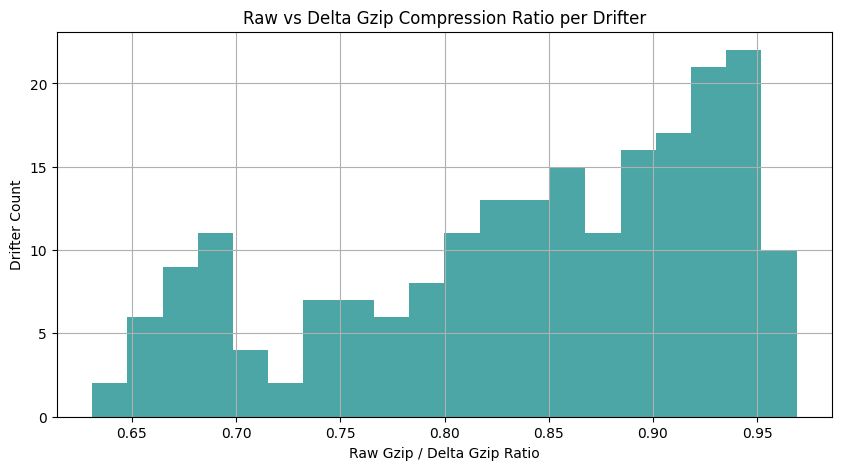


Estimated transmission energy consumption:
  Raw gzip: 116.2835 mJ
  Delta gzip: 84.7443 mJ
  Estimated energy savings: 27.12%


In [ ]:
import pandas as pd
import numpy as np
import gzip
import io
import os
import matplotlib.pyplot as plt

def gzip_compress(data_bytes):
    buf = io.BytesIO()
    with gzip.GzipFile(fileobj=buf, mode='wb') as f_out:
        f_out.write(data_bytes)
    return buf.getvalue()

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['lon360'] = pd.to_numeric(df['lon360'], errors='coerce')

def delta_encode(group):
    group = group.sort_values('time').reset_index(drop=True)
    group['lat_delta'] = group['latitude'].diff().fillna(0)
    group['lon_delta'] = group['lon360'].diff().fillna(0)
    return group

df_delta = df.groupby('ID', group_keys=False).apply(delta_encode).reset_index(drop=True)
delta_df = df_delta[['ID', 'time', 'lat_delta', 'lon_delta']].copy()
delta_df['lat_delta'] = delta_df['lat_delta'].round(5)
delta_df['lon_delta'] = delta_df['lon_delta'].round(5)

raw_csv_bytes = df[['ID', 'time', 'latitude', 'lon360']].to_csv(index=False).encode('utf-8')
delta_csv_bytes = delta_df.to_csv(index=False).encode('utf-8')
raw_gzip_bytes = gzip_compress(raw_csv_bytes)
delta_gzip_bytes = gzip_compress(delta_csv_bytes)

print(f"Global raw CSV size: {len(raw_csv_bytes)} bytes")
print(f"Global delta CSV size: {len(delta_csv_bytes)} bytes")
print(f"Global raw gzip size: {len(raw_gzip_bytes)} bytes")
print(f"Global delta gzip size: {len(delta_gzip_bytes)} bytes")

os.makedirs('compressed_data', exist_ok=True)
with open('compressed_data/raw.csv.gz', 'wb') as f:
    f.write(raw_gzip_bytes)
with open('compressed_data/delta.csv.gz', 'wb') as f:
    f.write(delta_gzip_bytes)
print("Saved compressed files to 'compressed_data/'")

drifter_stats = []
for drifter_id, group in df.groupby('ID'):
    raw_bytes = group[['ID', 'time', 'latitude', 'lon360']].to_csv(index=False).encode('utf-8')
    delta_group = delta_encode(group)
    delta_bytes = delta_group[['ID', 'time', 'lat_delta', 'lon_delta']].to_csv(index=False).encode('utf-8')
    raw_gzip = gzip_compress(raw_bytes)
    delta_gzip = gzip_compress(delta_bytes)
    drifter_stats.append({
        'ID': drifter_id,
        'raw_size': len(raw_bytes),
        'delta_size': len(delta_bytes),
        'raw_gzip_size': len(raw_gzip),
        'delta_gzip_size': len(delta_gzip),
        'gzip_ratio': len(raw_gzip) / len(delta_gzip) if len(delta_gzip) > 0 else np.nan,
        'uncompressed_ratio': len(raw_bytes) / len(delta_bytes) if len(delta_bytes) > 0 else np.nan
    })

stats_df = pd.DataFrame(drifter_stats)
print("\nCompression Summary Per Drifter:")
print(stats_df.describe().round(2))
plt.figure(figsize=(10, 5))
plt.hist(stats_df['gzip_ratio'].dropna(), bins=20, color='teal', alpha=0.7)
plt.title('Raw vs Delta Gzip Compression Ratio per Drifter')
plt.xlabel('Raw Gzip / Delta Gzip Ratio')
plt.ylabel('Drifter Count')
plt.grid(True)
plt.show()
energy_per_kb_mj = 0.1 
energy_raw = len(raw_gzip_bytes) / 1024 * energy_per_kb_mj
energy_delta = len(delta_gzip_bytes) / 1024 * energy_per_kb_mj
energy_savings_percent = 100 * (energy_raw - energy_delta) / energy_raw
print(f"\nEstimated transmission energy consumption:")
print(f"  Raw gzip: {energy_raw:.4f} mJ")
print(f"  Delta gzip: {energy_delta:.4f} mJ")
print(f"  Estimated energy savings: {energy_savings_percent:.2f}%")
